In [8]:
import sys
sys.path.append('../..')
from DLBio import pt_training
import ds_ear
from torchvision.models.mobilenet import mobilenet_v2
import torch.nn as nn
from torch import cuda
from DLBio.pytorch_helpers import get_device, get_num_params
from DLBio.helpers import check_mkdir
from DLBio.pt_train_printer import Printer
import json
import matplotlib.pyplot as plt
from os.path import join
import numpy as np

In [9]:
class Classification(pt_training.ITrainInterface):
    def __init__(self, model, device):
        self.model = model
        self.xent_loss = nn.CrossEntropyLoss()
        self.metrics = {
            'acc': accuracy
        }
        self.d = device

    def train_step(self, sample):
        images, targets = sample[0].to(self.d), sample[1].to(self.d)
        pred = self.model(images)

        loss = self.xent_loss(pred, targets)
        metrics = dict()

        metrics.update({k: v(pred, targets) for k, v in self.metrics.items()})

        return loss, metrics


def accuracy(y_pred, y_true):
    _, y_pred = y_pred.max(1)  # grab class predictions
    return (y_pred == y_true).float().mean().item()

In [13]:
# influences learning rate, weight decay, data folder path and training classes
IS_OWN_DATASET = True

# define constants
LEARNING_RATE = (0.001, 0.0001)[IS_OWN_DATASET] # FORM: (AMI, dataset)
WEIGHT_DECAY = (0.1, 0.1)[IS_OWN_DATASET] # FORM: (AMI, dataset)
DATASET_FOLDER = ('../AMI', '../dataset')[IS_OWN_DATASET]
MAP_TO_CLASSES = (100, 5)[IS_OWN_DATASET]

FOLDER = './class_sample'
OPT_TYPE = 'Adam'
EPOCHS = 9
LR_STEPS = 3
DO_EARLY_STOPPING = True
STOP_AFTER = 10
ES_METRIC = 'val_acc'
SAVE_INTERVALL = -1
PRINT_FREQUENCY = 500 # print every 500 batches
SEED = 0
BATCH_SIZE = 32
NUM_WORKERS = 1

# use seeds to ensure comparable results ()
# pt_training.set_random_seed(SEED)
# np.random.seed(SEED)

model = mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=MAP_TO_CLASSES)
# model.classifier.add_module("2", nn.Linear(1000, MAP_TO_CLASSES))

if cuda.is_available():
    model.to('cuda')

# apply to device
# device = get_device()
# print(device)
# model = model.to(device)

# define folder to save model and log file
check_mkdir(FOLDER, is_dir=True)
model_out = join(FOLDER, 'model.pt')
log_file = join(FOLDER, 'log.json')

False


In [6]:
# write some model specs
with open(join(FOLDER, 'model_specs.json'), 'w') as file:
    json.dump({
        'num_trainable': float(get_num_params(model, True)),
        'num_params': float(get_num_params(model, False))
    }, file)

# define indicies to split Data
N = len(ds_ear.get_dataset(DATASET_FOLDER))
n_80 = int(.8*N)
n_60 = int(.6*N)
n_20 = int(.2*N)

rand_indeces = np.random.permutation(N)
train_indeces = rand_indeces[:n_80]
valid_indeces = rand_indeces[n_80:]
#valid_indeces = rand_indeces[n_60:n_60+n_20]
#test_indeces = rand_indeces[n_60+n_20:]

# definde data loader
dl_train = ds_ear.get_dataloader(
    indeces=train_indeces,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    is_train=True,
    data_path=DATASET_FOLDER
)

dl_valid = ds_ear.get_dataloader(
    indeces=valid_indeces,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    is_train=False,
    data_path=DATASET_FOLDER
)

# dl_test = ds_ear.get_dataloader(
#     indeces=test_indeces,
#     batch_size=BATCH_SIZE,
#     num_workers=NUM_WORKERS,
#     is_train=False
# )

# with open('test_indizes.txt', 'w') as file:
#     for idx in test_indeces:
#         file.write("%i\n" % idx)


# define optimizer
optimizer = pt_training.get_optimizer(
        'Adam', model.parameters(),
        LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )

if LR_STEPS > 0:
    scheduler = pt_training.get_scheduler(
            LR_STEPS, EPOCHS, optimizer)

if DO_EARLY_STOPPING:
    assert SAVE_INTERVALL == -1
    early_stopping = pt_training.EarlyStopping(
            ES_METRIC, get_max=True, epoch_thres=STOP_AFTER
        )
else:
    early_stopping = None
    
train_interface = Classification(model, device)

training = pt_training.Training(
        optimizer, dl_train, train_interface,
        scheduler=scheduler, printer=Printer(PRINT_FREQUENCY, log_file),
        save_path=model_out, save_steps=SAVE_INTERVALL,
        val_data_loader=dl_valid,
        early_stopping=early_stopping
    )

training(EPOCHS)


FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: '../dataset'

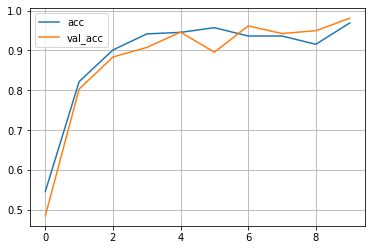

In [5]:
with open(log_file, 'r') as file:
    log = json.load(file)

plt.plot(log['acc'], label='acc')
plt.plot(log['val_acc'], label='val_acc')
plt.legend()
plt.grid()

In [5]:
# Execute this cell if you want the current variables to be added to the csv-file
import csv

with open('var_log.csv', 'a') as f:
    writer = csv.writer(f, delimiter=',', lineterminator='\n')
    writer.writerow([
        LEARNING_RATE,
        WEIGHT_DECAY,
        MAP_TO_CLASSES,
        OPT_TYPE,
        EPOCHS,
        LR_STEPS,
        DO_EARLY_STOPPING,
        STOP_AFTER,
        SEED,
        BATCH_SIZE,
        NUM_WORKERS,
        # insert optional comment
        ""
    ])
f.close()

